In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import truncnorm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.model_selection import GridSearchCV, PredefinedSplit

from pysim import SimBoostRegressor, SimAdaBoostClassifier, SimLogitBoostClassifier

## Regression

```python
from pysim import SimBoostRegressor
clf = SimBoostRegressor(n_estimators, val_ratio=0.2, early_stop_thres=1, spline="a_spline", degree=2, knot_num=20, reg_lambda=0.1, reg_gamma=10, random_state=0)
```

In [2]:
def data_generator1_reg(random_state=0):
    
    np.random.seed(random_state)
    # data generation
    beta1 = np.array([.2, 0.3, 0.5, 0, 0, 0, 0, 0, 0, 0])
    beta2 = np.array([0, .2, 0.3, 0.5, 0, 0, 0, 0, 0, 0])
    beta3 = np.array([0, 0, 0.2, 0.3, 0.5, 0, 0, 0, 0, 0])
    
    beta = np.vstack([beta1,beta2,beta3])
    model_list = [lambda x: 0.2*np.exp(-4*x), lambda x: 3*x**2, lambda x: 2.5*np.sin(1.5 * np.pi*x)]
    
    x = truncnorm.rvs(a=-3,b=3,loc = 0, scale=1/3, size=(20000,10),random_state=random_state)
    noise = np.random.randn(20000).reshape(-1, 1)
    y = np.reshape(0.2 * np.exp(-4 * np.dot(x, beta1)) + \
                   3 * (np.dot(x, beta2))**2 + 2.5 * np.sin(np.pi * 1.5 * np.dot(x, beta3)), [-1, 1]) + noise
    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=random_state)
    return beta, model_list, train_x, test_x, train_y, test_y

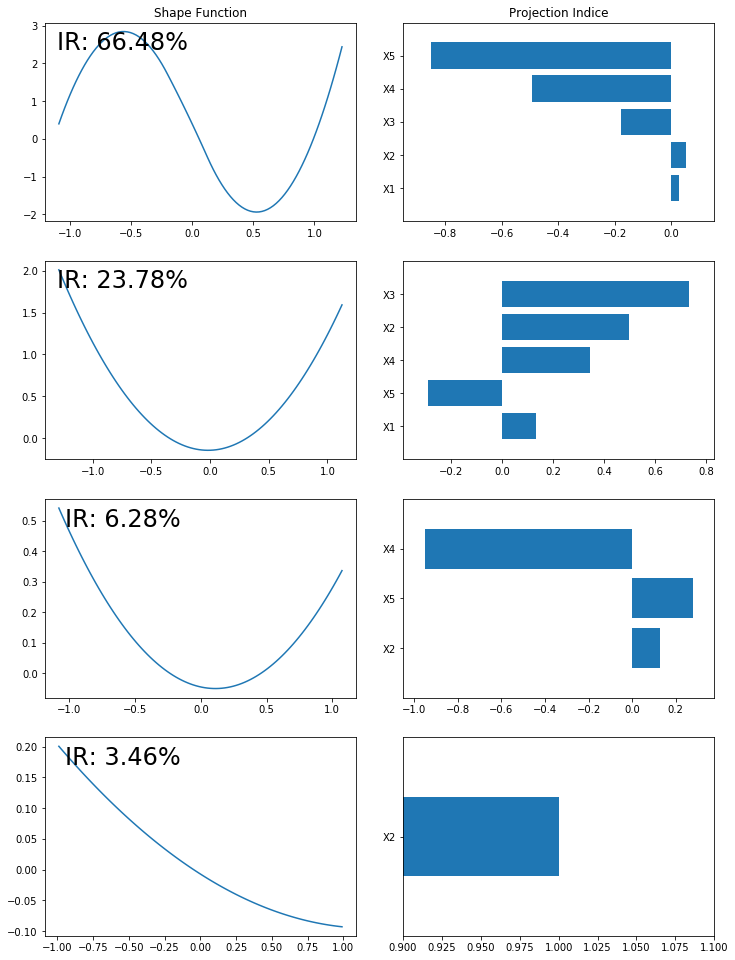

1.0245661197811755

In [3]:
beta, model_list, train_x, test_x, train_y, test_y = data_generator1_reg()

clf = SimBoostRegressor(n_estimators=5, early_stop_thres=1, knot_num=20, reg_lambda=0.05, reg_gamma=10)

clf.fit(train_x, train_y)
clf.visualize()
mean_squared_error(test_y, clf.predict(test_x))

## LogitBoost

```python
from pysim import SimLogitBoostClassifier
clf = SimLogitBoostClassifier(n_estimators, val_ratio=0.2, early_stop_thres=1, spline="a_spline", degree=2, knot_num=20, reg_lambda=0.1, reg_gamma=10, random_state=0)
```

In [4]:
def data_generator1_cls(random_state=0):
    
    np.random.seed(random_state)
    # data generation
    beta1 = np.array([.2, 0.3, 0.5, 0, 0, 0, 0, 0, 0, 0])
    beta2 = np.array([0, .2, 0.3, 0.5, 0, 0, 0, 0, 0, 0])
    beta3 = np.array([0, 0, 0.2, 0.3, 0.5, 0, 0, 0, 0, 0])
    
    beta = np.vstack([beta1,beta2,beta3])
    model_list = [lambda x: 0.2*np.exp(-4*x), lambda x: 3*x**2, lambda x: 2.5*np.sin(1.5 * np.pi*x)]
    
    x = truncnorm.rvs(a=-3, b=3, loc = 0, scale=1/3, size=(10000, 10),random_state=random_state)
    noise = np.random.randn(10000).reshape(-1, 1)
    y = np.reshape(0.2 * np.exp(-4 * np.dot(x, beta1)) + \
                   3 * (np.dot(x, beta2))**2 + 2.5 * np.sin(np.pi * 1.5 * np.dot(x, beta3)), [-1, 1]) + noise
    y[y <= 0] = 0
    y[y > 0] = 1
    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=random_state)
    return beta, model_list, train_x, test_x, train_y, test_y

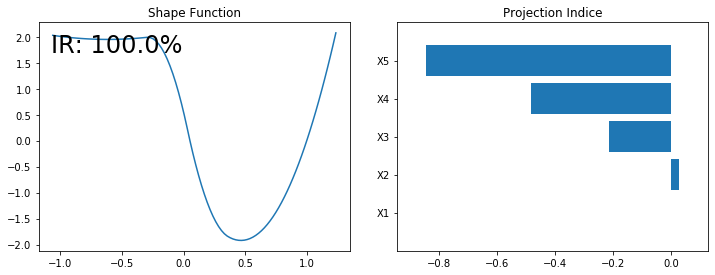

0.9203222619138102

In [5]:
beta, model_list, train_x, test_x, train_y, test_y = data_generator1_cls()

clf = SimLogitBoostClassifier(n_estimators=5, early_stop_thres=1, knot_num=20, reg_lambda=0.05, reg_gamma=10)
clf.fit(train_x, train_y)
clf.visualize()
roc_auc_score(test_y, clf.predict_proba(test_x))

## AdaBoost

```python
from pysim import SimLogitBoostClassifier
clf = SimLogitBoostClassifier(n_estimators, val_ratio=0.2, early_stop_thres=1, spline="a_spline", degree=2, knot_num=20, reg_lambda=0.1, reg_gamma=10, random_state=0)
```

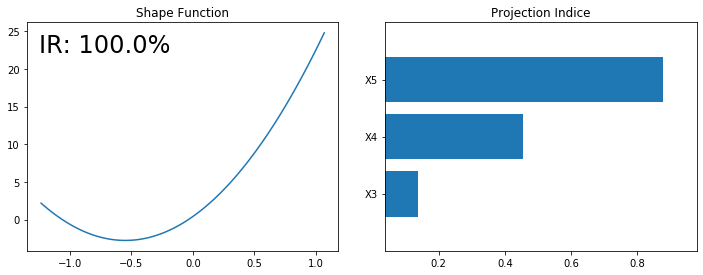

0.9141921917357048

In [6]:
beta, model_list, train_x, test_x, train_y, test_y = data_generator1_cls()

clf = SimAdaBoostClassifier(n_estimators=5, early_stop_thres=1, knot_num=20, reg_lambda=0.05, reg_gamma=10)
clf.fit(train_x, train_y)
clf.visualize()
roc_auc_score(test_y, clf.predict_proba(test_x))